## Testiranje modela


In [1]:
from settings import *
from pprint import pformat
from fastai.vision.all import load_learner
import os


model_picks = next(os.walk("./models"))[1]
# model_picks = ["alexnet_3x"]
seen = set()
testees = {}


for model in sorted(model_picks):
    spot = Path(garage / model_picks[0])
    try: 
        spot = Path(garage / model)
        print(spot)
    except NameError:
        print(f"model was not defined. Going with {model_picks[0]}.")
    signature = pformat(spot)
    if signature not in seen:
        seen.add(signature)
        try:
            testees[model] = {
                "breadth": load_learner(spot/"breadth.pkl"),
                "depth": load_learner(spot/"depth.pkl")
            }
        except Exception as ex:
            print(f"Model {model} is not trained yet!")
            print(ex)

testees

models/alexnet_10x
models/alexnet_1x
models/alexnet_3x
models/googlenet_10x
models/googlenet_1x
models/googlenet_3x
models/vgg11_bn_10x
models/vgg11_bn_1x
models/vgg11_bn_3x


{'alexnet_10x': {'breadth': <fastai.learner.Learner at 0x7ff2c113f250>,
  'depth': <fastai.learner.Learner at 0x7ff2c1148590>},
 'alexnet_1x': {'breadth': <fastai.learner.Learner at 0x7ff2c0f74110>,
  'depth': <fastai.learner.Learner at 0x7ff2c0fd38d0>},
 'alexnet_3x': {'breadth': <fastai.learner.Learner at 0x7ff2c113f810>,
  'depth': <fastai.learner.Learner at 0x7ff2c0fa9850>},
 'googlenet_10x': {'breadth': <fastai.learner.Learner at 0x7ff2c10217d0>,
  'depth': <fastai.learner.Learner at 0x7ff2be47de90>},
 'googlenet_1x': {'breadth': <fastai.learner.Learner at 0x7ff2be4b1110>,
  'depth': <fastai.learner.Learner at 0x7ff2c121c790>},
 'googlenet_3x': {'breadth': <fastai.learner.Learner at 0x7ff2c0fbded0>,
  'depth': <fastai.learner.Learner at 0x7ff2c120de10>},
 'vgg11_bn_10x': {'breadth': <fastai.learner.Learner at 0x7ff2bdbe7f90>,
  'depth': <fastai.learner.Learner at 0x7ff2bcc8edd0>},
 'vgg11_bn_1x': {'breadth': <fastai.learner.Learner at 0x7ff2bd416810>,
  'depth': <fastai.learner.Le

### Testiranje na bazi


In [4]:
import pandas as pd

df = pd.read_parquet("data/wikiart_composed.parquet")
df.head()

,artistName,title,year,style,genre,photography,artemis,emotions,Is painting,Face/body,Rating,artistContentId,artistUrl,paintingUrl,localUrl,webUrl,webUrl2
contentId,,,,,,,,,,,,,,,,,
314345,Hans von Aachen,Augustus and the Tiburtine Sibyl,1580,Mannerism (Late Renaissance),mythological painting,0,None,None,NaN,NaN,NaN,314332,hans-von-aachen,augustus-and-the-tiburtine-sibyl-1580,./wikiart/wikidata/images/hans-von-aachen/1580/314345.jpg,https://uploads6.wikiart.org/images/hans-von-aachen/augustus-and-the-tiburtine-sibyl-1580.jpg!Large.jpg,None
314363,Hans von Aachen,Portrait of Jacopo Biliverti,1585,Mannerism (Late Renaissance),portrait,0,None,None,NaN,NaN,NaN,314332,hans-von-aachen,portrait-of-jacopo-biliverti-1585,./wikiart/wikidata/images/hans-von-aachen/1585/314363.jpg,https://uploads2.wikiart.org/images/hans-von-aachen/portrait-of-jacopo-biliverti-1585.jpg!Large.jpg,None
314364,Hans von Aachen,Portrait of Joseph Heintz,1585,Mannerism (Late Renaissance),portrait,0,None,None,NaN,NaN,NaN,314332,hans-von-aachen,portrait-of-joseph-heintz-1585,./wikiart/wikidata/images/hans-von-aachen/1585/314364.jpg,https://uploads8.wikiart.org/images/hans-von-aachen/portrait-of-joseph-heintz-1585.jpg!Large.jpg,None
314371,Hans von Aachen,The rape of Proserpine,1587,Mannerism (Late Renaissance),mythological painting,0,None,None,NaN,NaN,NaN,314332,hans-von-aachen,the-rape-of-proserpine-1587,./wikiart/wikidata/images/hans-von-aachen/1587/314371.jpg,https://uploads5.wikiart.org/images/hans-von-aachen/the-rape-of-proserpine-1587.jpg!Large.jpg,None
314369,Hans von Aachen,The judgment of Paris,1588,Mannerism (Late Renaissance),mythological painting,0,None,None,NaN,NaN,NaN,314332,hans-von-aachen,the-judgment-of-paris-1588,./wikiart/wikidata/images/hans-von-aachen/1588/314369.jpg,https://uploads4.wikiart.org/images/hans-von-aachen/the-judgment-of-paris-1588.jpg!Large.jpg,None


In [ ]:
from utils.tester import predict_columns

# prođi kroz bazu u malim batchevima i spremi u datoteke
dataset = df.loc[~df["artemis"].isna() | ~df["emotions"].isna()].sample(1000)
datafiles = {}
for model_name, testee in testees.items(): 
    datafiles[model_name] = predict_columns(testee, dataset, model_name, root);

In [4]:
# spoji kreirane batch datoteke u jednu (ako je gore uzeti uzorak bio do 1000 jedinica, onda se ova čelija može preskočiti)
for model_name, addresses in datafiles.items():
    result = pd.DataFrame()
    for adress in addresses:
        data = pd.read_parquet(adress)
        result = pd.concat((result, data))

    result[["artistName", "title", "year", "style", "breadth", "breadth_probs", "depth", "depth_probs", "genre", "artemis", "emotions", "webUrl"]].to_parquet(f"data/{model_name}/critic_full.parquet")

## Analiza predviđanja na neviđenom uzorku

In [2]:
model_picks.sort()
model_picks

['alexnet_10x',
 'alexnet_1x',
 'alexnet_3x',
 'googlenet_10x',
 'googlenet_1x',
 'googlenet_3x',
 'vgg11_bn_10x',
 'vgg11_bn_1x',
 'vgg11_bn_3x']

In [5]:
model_predictions = {}
for model in model_picks:
    model_predictions[model] = pd.read_parquet(Path("./data")/model/"critic_output1.parquet")
model = model_picks[3]
preds = model_predictions[model]
preds.sample(3)

,artistName,title,year,style,breadth,breadth_probs,depth,depth_probs,genre,artemis,emotions,webUrl
242455,Tsukioka Yoshitoshi,Yoshitsune with benkei,NaN,Ukiyo-e,abstract,0.950879,symbolic,0.043033,genre painting,"excitement, contentment, amusement",None,https://uploads4.wikiart.org/images/tsukioka-yoshitoshi/yoshitsune-with-benkei.jpg
304835,Auguste Herbin,Composition monumentale,1919.0,"Abstract Art, Cubism",abstract,1.000000,symbolic,0.000003,abstract,None,surprise,https://uploads5.wikiart.org/images/auguste-herbin/composition-monumentale-1919.jpg
271534,Dimitris Mytaras,Untitled,NaN,Expressionism,abstract,0.881052,symbolic,0.007679,portrait,"excitement, fear, something else, awe",None,https://uploads8.wikiart.org/images/dimitris-mytaras/untitled(7).jpg


In [6]:
preds.describe()

,year,breadth_probs,depth_probs
count,683.000000,1.000000e+03,1.000000e+03
mean,1879.989751,4.733908e-01,6.191473e-01
std,137.908906,4.694516e-01,4.122708e-01
min,1436.000000,1.037809e-11,7.260302e-07
25%,1885.000000,2.992939e-04,1.252313e-01
50%,1925.000000,2.993215e-01,8.497476e-01
75%,1961.000000,9.999173e-01,9.952635e-01
max,2007.000000,1.000000e+00,1.000000e+00


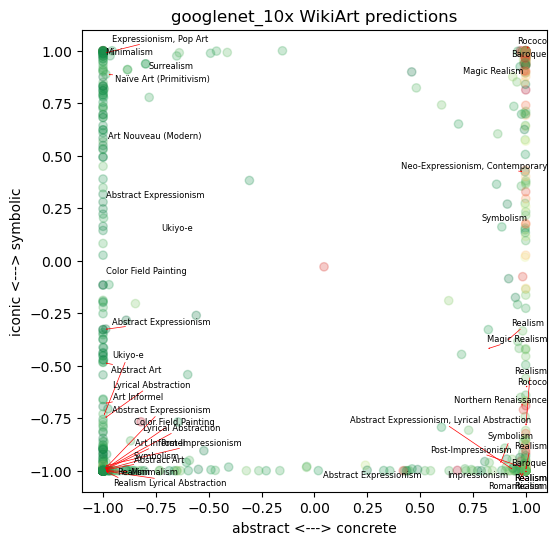

In [23]:
from fastai.vision.all import *
from adjustText import adjust_text

norm = plt.Normalize(1,4)
fig, ax = plt.subplots(figsize=(6,6))
cmap = plt.cm.RdYlGn
c = preds["year"]

def coord(prob):
    return ((1-prob)**2 - .5)*2
x, y = coord(preds.breadth_probs), coord(preds.depth_probs) 
sc = plt.scatter(x=x, y=y, c=c, cmap=cmap, alpha=.25)
plt.title(f"{model} WikiArt predictions")
plt.xlabel("abstract <---> concrete")
plt.ylabel("iconic <---> symbolic")

# samples = preds.loc[(preds.breadth_probs > .05) & (preds.breadth_probs < .95)].sample(16)
samples = preds.sample(45)
annotations = []
for _, sample in samples.iterrows():
    # print(sample["style"])
    # plt.annotate(sample['style'], (coord(sample.breadth_probs), coord(sample.depth_probs)), fontsize=6)
    annotations.append(plt.text(coord(sample.breadth_probs), coord(sample.depth_probs), sample['style'], size=6))

adjust_text(annotations, x=samples["breadth_probs"].apply(coord).values, y=samples["depth_probs"].apply(coord).values, 
            only_move={'points':'y', 'text':'y'}, 
            arrowprops=dict(arrowstyle="->", color="r", lw=.5)
            )

plt.show()

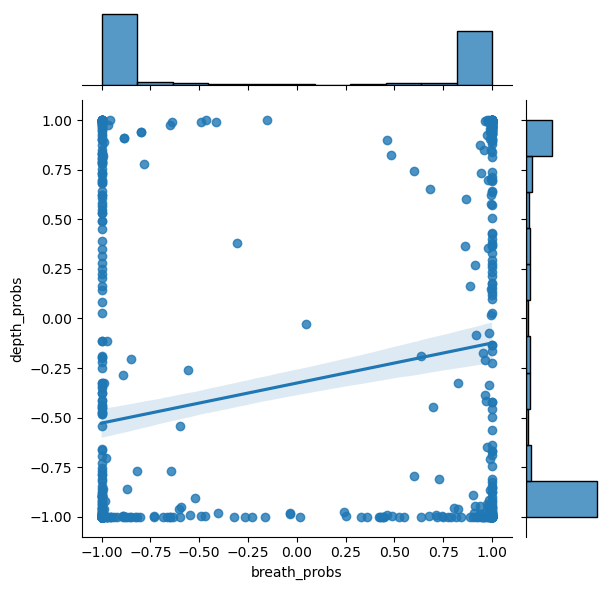

In [24]:
import seaborn as sns

new_df = preds.copy()
new_df = new_df.dropna(subset=['year'])
# new_df = new_df.rename(columns={"year": "target"})
x, y = new_df["breadth_probs"].apply(coord), new_df["depth_probs"].apply(coord)

g = sns.JointGrid(data=new_df, x=x, y=y)
g.set_axis_labels(xlabel="abstract <---> concrete", ylabel="iconic <---> symbolic")
g.plot(sns.regplot, sns.histplot)

In [25]:
new_df.sample()

,artistName,title,year,style,breadth,breadth_probs,depth,depth_probs,genre,artemis,emotions,webUrl
222130,Paul Klee,Death for the Idea,1915.0,Expressionism,abstract,0.999959,iconic,0.999961,symbolic painting,None,surprise,https://uploads4.wikiart.org/images/paul-klee/death-for-the-idea-1915.jpg


#### Provjera zavisnosti ciljane varijable s semantičkim dimenzijama

<function matplotlib.pyplot.show(close=None, block=None)>

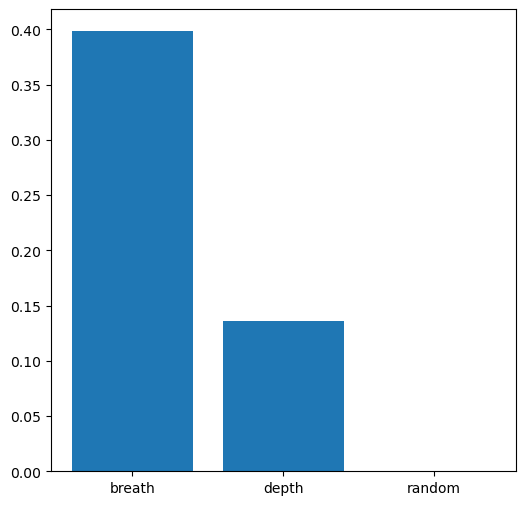

In [62]:

from sklearn.feature_selection import mutual_info_classif as mir
import numpy as np

new_df["random"] = np.random.uniform(0,1, new_df.shape[0])
features, target =  ["breadth_probs", "depth_probs", "random"], "year"
# df_mi = pd.DataFrame([mir(new_df[feature], new_df[target]) for feature in features], index = target, columns = features.columns).apply(lambda x: x / x.max(), axis = 1)
mi = mir(new_df[features], new_df[target])
labels = ["breadth", "depth", "random"]

fig, ax = subplots(figsize=(6,6))
# pd.DataFrame({"feature": features, "vimp": mi}).set_index("feature").plot.barh(ax=ax)
mip = plt.bar(labels, mi, width=0.8)
plt.show


### Testiranje na web stranicama


In [6]:
from utils.downloader import page_scraper
from utils.tester import test_learners

# "https://aiartists.org/generative-art-design"
# "https://unsplash.com"
# "https://www.metmuseum.org/art/collection/search?showOnly=openAccess"
# "https://www.gettyimages.com"

internet = [
    *page_scraper("https://www.gettyimages.com"),
]

# "https://tse2.mm.bing.net/th?id=OIP.UPZ1-G8gpc5FkNIC2RCWSgHaFj&pid=Api",
# "https://tse2.mm.bing.net/th?id=OIP.if_cidFAKZ49wY7BLA3feQHaGE&pid=Api",
# "https://tse4.mm.bing.net/th?id=OIP.Px4ySbgcqEgFJOhOq8k5mAHaEo&pid=Api",
# "https://tse4.mm.bing.net/th?id=OIP.eNfpYf9Oqyh0u3_b1Eu20wHaGL&pid=Api",
# "https://tse3.mm.bing.net/th?id=OIP.NEkbbYyu56hdqekgPKxmoQAAAA&pid=Api",
# "https://tse3.mm.bing.net/th?id=OIF.jw1Qziy4XGJbDtTYtrBY3Q&pid=Api",
# "https://tse2.mm.bing.net/th?id=OIP.pJwVOqij6rPFrOjcHc1jbAHaKj&pid=Api",
# "https://tse1.mm.bing.net/th?id=OIP.-Hy08hdnnfvCwor0Y_fyGAHaLA&pid=Api",
# "https://tse4.mm.bing.net/th?id=OIP.mUVhO-Zld2qEJKe_r9tJaAHaHn&pid=Api",
# "https://tse2.mm.bing.net/th?id=OIP.DqjuCxnocoFQ0hvIH_Cm8wHaEK&pid=Api",
# "https://tse1.mm.bing.net/th?id=OIP.EFoByYTKu1KbZgoVfocCDAHaFU&pid=Api",
# "https://tse2.mm.bing.net/th?id=OIP.BFRcQqZ5Bpw1a-6u_XoBrwHaFj&pid=Api",
# "https://tse2.mm.bing.net/th?id=OIP.2qqjQQ0wW37Lbvkx50zPxgHaEB&pid=Api"

for model_name, testee in testees.items():
    test_learners(testee, test_set=internet, model_name=model_name, root=root/"artefacts", preview=False)

['https://static.gettyimages.com/display-sets/creative-landing/images/GettyImages-2131911406.jpg', 'https://static.gettyimages.com/display-sets/creative-landing/images/GettyImages-1995304390.jpg', 'https://static.gettyimages.com/display-sets/creative-landing/images/GettyImages-2086233684.jpg', 'https://static.gettyimages.com/display-sets/creative-landing/images/GettyImages-1820574038.jpg', 'https://static.gettyimages.com/display-sets/creative-landing/images/GettyImages-2112002315.jpg', 'https://static.gettyimages.com/display-sets/creative-landing/images/GettyImages-1939317654.jpg', 'https://static.gettyimages.com/display-sets/creative-landing/images/GettyImages-2116292040.jpg', 'https://static.gettyimages.com/display-sets/creative-landing/images/GettyImages-1859049658.jpg', 'https://static.gettyimages.com/display-sets/creative-landing/images/GettyImages-2043042354.jpg', 'https://static.gettyimages.com/display-sets/creative-landing/images/GettyImages-2039536981.jpg', 'https://static.get

Image test1.jpg is concrete.
('abstract', 0.0010556999) ('concrete', 0.99894434)


Image test1.jpg is iconic.
('iconic', 0.67403936) ('symbolic', 0.3259606)


#%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%#
- 2 - 2 - 2 - 2 - 2 - 2 - 2 - 2 - 2 - 2 - 2 - 2 - 2 - 2 - 2 - 


Image test2.jpg is concrete.
('abstract', 4.013242e-06) ('concrete', 0.99999595)


Image test2.jpg is symbolic.
('iconic', 0.0764169) ('symbolic', 0.9235831)


#%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%#
- 3 - 3 - 3 - 3 - 3 - 3 - 3 - 3 - 3 - 3 - 3 - 3 - 3 - 3 - 3 - 


Image test3.jpg is concrete.
('abstract', 0.04495972) ('concrete', 0.95504034)


Image test3.jpg is symbolic.
('iconic', 0.32102478) ('symbolic', 0.67897516)


#%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%#
- 4 - 4 - 4 - 4 - 4 - 4 - 4 - 4 - 4 - 4 - 4 - 4 - 4 - 4 - 4 - 


Image test4.jpg is concrete.
('abstract', 0.00617949) ('concrete', 0.9938205)


Image test4.jpg is iconic.
('iconic', 0.989876) ('symbolic', 0.010123977)


#%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%#
- 5 - 5 - 5 - 5 - 5 - 5 - 5 - 5 - 5 - 5 - 5 - 5 - 5 - 5 - 5 - 


Image test5.jpg is concrete.
('abstract', 1.5874755e-07) ('concrete', 0.9999999)


Image test5.jpg is symbolic.
('iconic', 0.31339446) ('symbolic', 0.6866055)


#%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%#
- 6 - 6 - 6 - 6 - 6 - 6 - 6 - 6 - 6 - 6 - 6 - 6 - 6 - 6 - 6 - 


Image test6.jpg is concrete.
('abstract', 0.33989784) ('concrete', 0.6601022)


Image test6.jpg is iconic.
('iconic', 0.66484624) ('symbolic', 0.33515376)


#%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%#
- 7 - 7 - 7 - 7 - 7 - 7 - 7 - 7 - 7 - 7 - 7 - 7 - 7 - 7 - 7 - 


Image test7.jpg is concrete.
('abstract', 0.021127649) ('concrete', 0.97887236)


Image test7.jpg is iconic.
('iconic', 0.98572135) ('symbolic', 0.014278632)


#%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%#
- 8 - 8 - 8 - 8 - 8 - 8 - 8 - 8 - 8 - 8 - 8 - 8 - 8 - 8 - 8 - 


Image test8.jpg is concrete.
('abstract', 0.0063189166) ('concrete', 0.9936811)


Image test8.jpg is symbolic.
('iconic', 0.1629952) ('symbolic', 0.83700484)


#%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%##%&%#
- 9 - 9 - 9 - 9 - 9 - 9 - 9 - 9 - 9 - 9 - 9 - 9 - 9 - 9 - 9 - 


Image test9.jpg is abstract.
('abstract', 0.99998796) ('concrete', 1.2027528e-05)


Image test9.jpg is symbolic.
('iconic', 0.17957522) ('symbolic', 0.8204248)


In [7]:
import re 

html = 'aaa a ad <img image="tupo-_&$banana.jpeg 300w, milica0087Pilica.png 120w" /> safdsaf saf\
    \safdafa <img asf afasf srcset="data:image/bmp jJAJBDADHHANDKNDKAKNNDDMNANDMND" src="345a"/> \
    saf sa<img data-stretch="false" data-src="https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg" data-image="https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg" data-image-dimensions="1500x842" data-image-focal-point="0.5,0.5" alt="Generative Software Design Example - Procedural Modeling.jpeg" data-load="false" src="https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg" width="1500" height="842" alt="" sizes="100vw" style="display:block;object-fit: cover; width: 100%; height: 100%; object-position: 50% 50%" srcset="https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg?format=100w 100w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg?format=300w 300w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg?format=500w 500w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg?format=750w 750w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg?format=1000w 1000w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg?format=1500w 1500w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg?format=2500w 2500w" loading="lazy" decoding="async" data-loader="sqs">\
     ffasf asf asf <figure srcset= "https://pili?ćsss3245i.png" =src=><div style="background-image: url(http://vilinkonjic.jpeg )" >saf </div> \
        <img data-stretch="false" data-src="https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg" data-image="https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg" data-image-dimensions="1958x720" data-image-focal-point="0.5,0.5" alt="Silk Interactive Generative Art.jpg" data-load="false" src="https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg" width="1958" height="720" alt="" sizes="100vw" style="display:block;object-fit: cover; width: 100%; height: 100%; object-position: 50% 50%" srcset="https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg?format=100w 100w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg?format=300w 300w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg?format=500w 500w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg?format=750w 750w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg?format=1000w 1000w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg?format=1500w 1500w, https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg?format=2500w 2500w" loading="lazy" decoding="async" data-loader="sqs">'

src = "<(?:img|figure)[\s]*.*?(?:src|image)(?:set)?=[\"'\s]+((?:http)[^'\"\s]+(?:.jpg|.jpeg|.png|.gif|,))[^'\"]*?[\"']+.*?>"
bgurl = "url\([\s]*?((?:http)[^\"'\s]+(?:.jpg|.jpeg|.png))[^\"']*?\)"


re.findall(src, html, re.IGNORECASE), re.findall(bgurl, html, re.IGNORECASE)

(['https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588698548907-RADZYUVD1S7R2R7I0JMM/Generative+Software+Design+Example+-+Procedural+Modeling.jpeg',
  'https://pili?ćsss3245i.png',
  'https://images.squarespace-cdn.com/content/v1/5c77350965a707ed1710a1bc/1588703003192-B8US29YF5NDQZQK6WPUN/Silk+Interactive+Generative+Art.jpg'],
 ['http://vilinkonjic.jpeg'])